<h1 style="text-align: center;"><b>Heston model calibration</b></h1>

#### Dmitry Bazanov - MIPT
#### Roland Grinis - MIPT & GrinisRIT
#### Ivan Novikov - MIPT

This is a stochastic volatility model for the forward dynamics in the risk neutral measure, and CIR dynamics for the variance:
$$
\left\{
\begin{array}{l}
    \text{d}X_t =  \sqrt{V_t} X_t \text{d}W_t^X,  \\
    \text{d}V_t =  \kappa (\theta - V_t)\text{d}t + \varepsilon \sqrt{V_t} \text{d} W_t^V,
\end{array}\right.
$$

where underlying Brownian motions are correlated:
$$ \text{d} W_t^V = \rho\text{d}W_t^X + \sqrt{1-\rho^2} \text{d}W_t,$$
$$ -1 < \rho < 1. $$

The forward price of a call option is given by:
$$
\text{FV}_C(t_0, T, K) = X_{t_0} H(\sqrt{-1}) - K \cdot H(0)
$$
where
$$
H(z) = \frac{1}{2} + \frac{1}{\pi} \int^{\infty}_0 \mathbf{Re} \left[ \frac{e^{u\sqrt{-1} \log \frac{X_{t_0}}{K}}}{u\sqrt{-1}} \phi(u-z,T) \right]\text{d}u
$$
with 
$$
\phi(u,T) = \exp \left( - \frac{\kappa\theta\rho T u\sqrt{-1} }{\varepsilon} - A + \frac{2 \kappa \theta }{\varepsilon^2}D\right).
$$
Here $A = A_1 / A_2$:
$$
A_1 = (u^2 + u\sqrt{-1}) \sinh \frac{q T}{2}, \quad q = \sqrt{ \xi^2 + \varepsilon^2 (u^2 + u\sqrt{-1})}, \quad \xi = \kappa - \varepsilon\rho u\sqrt{-1}, \\
$$
$$
\log A_2 = \frac{q T}{2} + \log \left( \frac{q +\xi}{2 V_{t_0}} + \frac{q  - \xi}{2V_{t_0}}e^{-q T}\right),
$$

and
$$
D = \log \frac{q}{V_{t_0}} + \frac{\kappa T}{2} - \log A_2.
$$

The integral above can be truncated to $(0,200)$ and evaluated via Gaussian quadrature at 64 nodes for $10^{-10}$ accuracy.

# Delta 
Let's find Delta. See that:

$$\text{FV}_C(\lambda X_{t_0}, T, \lambda K) = \lambda \text{FV}_C(X_{t_0}, T, K).$$

So, formula is homogeneous of order one. Differentiating both sides with respect to $\lambda$:

$$X_{t_0} \frac{\partial \text{FV}_C}{\partial X_{t_0}} + K \frac{\partial \text{FV}_C}{\partial K} = \text{FV}_C.$$

Comparing with equation for call-option:

$$\Delta = \frac{\partial \text{FV}_C}{\partial X_{t_0}} = H(i).$$

## $\nu_0$

We can fix $\nu_0$ to $\sigma_{ATM}^2$ this way:

\begin{equation*}
\sigma_{ATM}^2 = 
 \begin{cases}
   \theta &\text{, $T >> 1$ }\\
   \nu_0 &\text{, $T << 1$ }
 \end{cases}
\end{equation*}

In our case $\theta$ can not be fixed to ATM, because we work with short-term maturities


1. Take closest expiration
2. Take closest forward out of the money put и call option per this expiration
3. Find their implied volatilities with Newton-Raphsen
4. Take average-weighted as ATM implied volatility:

  $$\sigma(f, K = f) = \sigma_{iv_{left}}\frac{f - K_{left}}{K_{right} - K_{left}} + \sigma_{iv_{right}}\frac{K_{right} - f}{K_{right} - K_{left}}$$


This is needed $\sigma_{ATM}^2$. Take it as $\nu_0$, others params are found via LM.



## $\theta$

$f_i$ - daily historical data on forward price

$$r_{t_i} = \frac{f_{t_i} - f_{t_{i-1}} }{f_{t_{i-1}} \sqrt{\delta t}}$$
$$\delta t = t_i - t_{i-1}$$
$$\theta = \frac{1}{n_{max}} \sum\limits_{i=0}^{-n_{max}} \left( r_{t_i} - \frac{1}{n_{max} + 1} \sum\limits_{i=0}^{-n_{max}} r_{t_i} \right)^2$$



## $\kappa$

$\alpha_t$ - historical daily volatility with window = 7 days.

Find $\theta$ and build linear regression to find $\kappa$, $\nu$:

$$\frac{\alpha_{t_{i+1}} - \alpha_{t_{i}}}{\sqrt{\alpha_{t_{i}}}}  = \frac{\theta \cdot \delta t - \alpha_{t_{i}}}{\sqrt{\alpha_{t_{i}}}} \cdot \kappa + \nu \sqrt{\delta t} \cdot \epsilon_i$$



# Implementation

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")
from matplotlib.pyplot import figure
import src.Heston.heston 
from importlib import reload
reload(src.Heston.heston)
from src.Heston.heston import calibrate_heston, get_tick
import datetime
from src.utils import process_data, round_params
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
from scipy import stats as sps
from typing import Union
import h5py
import matplotlib.dates as mdates
from tqdm.notebook import tqdm

In [2]:
%%time
# heavy
raw = pd.HDFStore('datasets/eth-20230224.h5','r').get("/eth")
# raw2 = pd.HDFStore('../datasets/eth-20230127.h5','r').get("/eth")
# raw3 = pd.HDFStore('../datasets/eth-20230310.h5','r').get("/eth")
# raw = pd.concat([raw1, raw2, raw3]).drop_duplicates()

CPU times: user 21.4 s, sys: 3.58 s, total: 25 s
Wall time: 27.3 s


<AxesSubplot: >

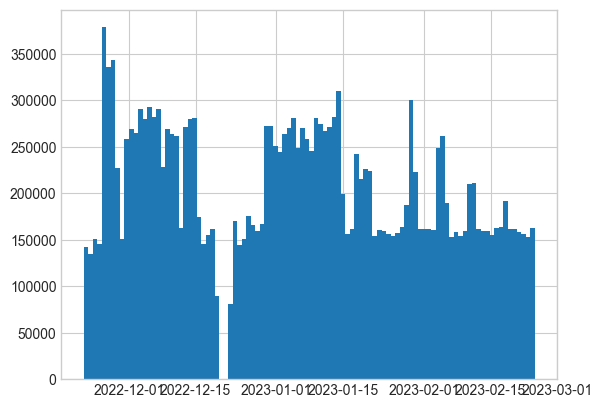

In [3]:
raw.dt.hist(bins = 100)

In [4]:
%%time
start = process_data(raw)


CPU times: user 49.8 s, sys: 22.3 s, total: 1min 12s
Wall time: 1min 24s


In [5]:
df = start.copy()
df

,dt,mark_price,instrument,type,strike_price,expiration,underlying_price,timestamp
0,2022-11-21 13:08:24.511,0.0005,ETH-25NOV22-1700-C,call,1700,1669334400000000,1133.90,1669036104511000
1,2022-11-21 13:08:24.511,0.0005,ETH-25NOV22-2400-C,call,2400,1669334400000000,1133.90,1669036104511000
2,2022-11-21 13:08:24.511,0.0020,ETH-25NOV22-700-P,put,700,1669334400000000,1133.90,1669036104511000
3,2022-11-21 13:08:24.511,0.0005,ETH-25NOV22-3800-C,call,3800,1669334400000000,1133.90,1669036104511000
4,2022-11-21 13:08:24.511,0.0005,ETH-25NOV22-3400-C,call,3400,1669334400000000,1133.90,1669036104511000
...,...,...,...,...,...,...,...,...
7498621,2023-02-24 07:13:46.716,0.0300,ETH-24FEB23-1700-P,put,1700,1677196800000000,1651.85,1677222826716000
7498622,2023-02-24 07:13:47.576,0.2975,ETH-24FEB23-1200-C,call,1200,1677196800000000,1651.85,1677222827576000
7498623,2023-02-24 07:13:51.208,0.0015,ETH-24FEB23-1650-P,put,1650,1677196800000000,1651.85,1677222831208000
7498624,2023-02-24 07:13:55.748,0.2980,ETH-24FEB23-1200-C,call,1200,1677196800000000,1651.85,1677222835748000


# See params dynamic

In [34]:
# fix to False if you don't want to calibrate this way
to_calibrate = {
    "all": False,
    "nu0": False,
    "nu0_and_nu_bar": False,
    "nu0_and_k": False,
    "kappa": False,
    "nu_bar_and_k": True
}

In [36]:
%%time
# in this setup calibration on one expiration
# calibrate base
number_of_dots = 50
timestamps_hm = []

params_all = []
params_nu0 = []
params_nu0_and_nu_bar = []
params_nu0_and_k = []
params_kappa = []
params_nu_bar_and_k = []


errors_all = []
errors_nu0 = []
errors_nu0_and_nu_bar = []
errors_nu0_and_k = []
errors_kappa = []
errors_nu_bar_and_k = []

a = np.float64(1.0)  # kappa    a                 |  mean reversion rate | kappa (Article) | kappa (Roland's)
b = np.float64(1.3)  # v_infinity                |  long term variance | nu_bar           | alpha_bar 
c = np.float64(1.0)  # sigma                    |  volatility of volatility | sigma      | mu
rho = np.float64(-0.4)  # rho                    |  correlation between spot and vol |rho | rho
v0 = np.float64(0.65) # init variance            | initial variance | nu_0                | alpha_0
start_params = np.array([a, b, c, rho, v0])

print("Optimize first params with random start once")
if to_calibrate["all"]:
    calibrated_params_all, first_error_all, _ = calibrate_heston(df = df, 
                                                            start_params = start_params, 
                                                            calibration_type = "all")
    print("All first calibrated:", round_params(calibrated_params_all), "error:", first_error_all)
    
if to_calibrate["nu0"]:
    calibrated_params_nu0, first_error_nu0, _ = calibrate_heston(df = df, 
                                                            start_params = start_params, 
                                                            calibration_type = "nu0")
    print("nu0 first calibrated:", round_params(calibrated_params_nu0), "error:", first_error_nu0)

if to_calibrate["nu0_and_nu_bar"]:
    calibrated_params_nu0_and_nu_bar, first_error_nu0_and_nu_bar, _ = calibrate_heston(df = df, 
                                                            start_params = start_params, 
                                                            calibration_type = "nu0_and_nu_bar")
    print("nu0_and_nu_bar first calibrated:", round_params(calibrated_params_nu0_and_nu_bar),
              "error:", first_error_nu0_and_nu_bar)
    
if to_calibrate["nu0_and_k"]:
    calibrated_params_nu0_and_k, first_error_nu0_and_k, _ = calibrate_heston(df = df, 
                                                            start_params = start_params, 
                                                            calibration_type = "nu0_and_k")
    print("nu0_and_k first calibrated:", round_params(calibrated_params_nu0_and_k),
              "error:", first_error_nu0_and_k)
    
if to_calibrate["kappa"]:   
    calibrated_params_kappa, first_error_kappa, _ = calibrate_heston(df = df, 
                                                            start_params = start_params, 
                                                       calibration_type = "kappa")
    print("kappa first calibrated:", round_params(calibrated_params_kappa),
              "error:", first_error_kappa)
    
if to_calibrate["nu_bar_and_k"]: 
    calibrated_params_nu_bar_and_k, first_error_nu_bar_and_k, _ = calibrate_heston(df = df, 
                                                            start_params = start_params, 
                                                            calibration_type = "nu_bar_and_k")
    print("nu_bar_and_k first calibrated:", round_params(calibrated_params_nu_bar_and_k),
              "error:", first_error_nu_bar_and_k)




# Get ticks with similar distnce from available data
calibr_borders = df[(df["dt"] >= "2023-02-04") & (df["dt"] <= "2023-02-04 12:00:00")].copy()
timestamps = np.linspace(calibr_borders.timestamp.min(), calibr_borders.timestamp.max(), number_of_dots)
for timestamp in tqdm(timestamps):
    try:
        # zero params for each point are params from last step
        if to_calibrate["all"]:
            calibrated_params_all, error_all, _ = calibrate_heston(df = df, start_params = calibrated_params_all, 
                                        timestamp = timestamp, calibration_type = "all")
            print("All calibrated:", round_params(calibrated_params_all), 
                  "error:", error_all)
            params_all.append(calibrated_params_all)
            errors_all.append(error_all)
        
        if to_calibrate["nu0"]:
            calibrated_params_nu0, error_nu0, _ = calibrate_heston(df = df, start_params = calibrated_params_nu0, 
                                        timestamp = timestamp, calibration_type = "nu0")
            print("nu0 calibrated:", round_params(calibrated_params_nu0), 
                  "error:", error_nu0)
            params_nu0.append(calibrated_params_nu0)
            errors_nu0.append(error_nu0)
        
        if to_calibrate["nu0_and_nu_bar"]:
            calibrated_params_nu0_and_nu_bar, error_nu0_and_nu_bar, _ = calibrate_heston(df = df, start_params = calibrated_params_nu0_and_nu_bar, 
                                        timestamp = timestamp, calibration_type = "nu0_and_nu_bar")
            print("nu0nb calibrated:", round_params(calibrated_params_nu0_and_nu_bar),
                  "error:", error_nu0_and_nu_bar)
            params_nu0_and_nu_bar.append(calibrated_params_nu0_and_nu_bar)
            errors_nu0_and_nu_bar.append(error_nu0_and_nu_bar)
        
        if to_calibrate["nu0_and_k"]:
            calibrated_params_nu0_and_k, error_nu0_and_k, _ = calibrate_heston(df = df, start_params = calibrated_params_nu0_and_k, 
                                        timestamp = timestamp, calibration_type = "nu0_and_k")
            print("nu0k calibrated:", round_params(calibrated_params_nu0_and_k),
                  "error:", error_nu0_and_k)
            params_nu0_and_k.append(calibrated_params_nu0_and_k)
            errors_nu0_and_k.append(error_nu0_and_k)
        
        if to_calibrate["kappa"]:
            calibrated_params_kappa, error_kappa, _ = calibrate_heston(df = df, start_params = calibrated_params_kappa, 
                                        timestamp = timestamp, calibration_type = "kappa")
            print("kappa calibrated:", round_params(calibrated_params_kappa),
                  "error:", error_kappa)
            params_kappa.append(calibrated_params_kappa)
            errors_kappa.append(error_kappa)
        
        if to_calibrate["nu_bar_and_k"]:
            calibrated_params_nu_bar_and_k, error_nu_bar_and_k, _ = calibrate_heston(df = df, start_params = calibrated_params_nu_bar_and_k, 
                                        timestamp = timestamp, calibration_type = "nu_bar_and_k")
            print("nu_bar_and_k calibrated:", round_params(calibrated_params_nu_bar_and_k),
                  "error:", error_nu_bar_and_k)
            params_nu_bar_and_k.append(calibrated_params_nu_bar_and_k)
            errors_nu_bar_and_k.append(error_nu_bar_and_k)
        
        print("    ")
        # save timestame that could calibrate
        timestamps_hm.append(timestamp)
    except:
        print("Error!")
        continue

    
timestamps_hm = [datetime.datetime.fromtimestamp(x/1000000.0) for x in timestamps_hm]

if to_calibrate["all"]:
    params_all = np.array(params_all).T
    
if to_calibrate["nu0"]:
    params_nu0 = np.array(params_nu0).T
    
if to_calibrate["nu0_and_nu_bar"]:
    params_nu0_and_nu_bar = np.array(params_nu0_and_nu_bar).T
    
if to_calibrate["nu0_and_k"]:
    params_nu0_and_k = np.array(params_nu0_and_k).T
    
if to_calibrate["kappa"]:
    params_kappa = np.array(params_kappa).T
    
if to_calibrate["nu_bar_and_k"]:
    params_nu_bar_and_k = np.array(params_nu_bar_and_k).T




Optimize first params with random start once
nu_bar_and_k first calibrated: [0.236, 0.0, 5.843, -0.089, 0.557] error: 0.2203529792113802


  0%|          | 0/50 [00:00<?, ?it/s]

nu_bar_and_k calibrated: [0.225, 0.001, 5.445, -0.059, 0.503] error: 0.15723821264455448
    
nu_bar_and_k calibrated: [0.225, 0.001, 5.566, -0.085, 0.505] error: 0.14865142202957873
    
nu_bar_and_k calibrated: [0.224, 0.001, 5.616, -0.084, 0.502] error: 0.14770749046396064
    
nu_bar_and_k calibrated: [0.224, 0.001, 5.555, -0.076, 0.502] error: 0.15649235799433758
    
nu_bar_and_k calibrated: [0.224, 0.001, 5.608, -0.063, 0.502] error: 0.15259021345090704
    
nu_bar_and_k calibrated: [0.223, 0.001, 5.521, -0.07, 0.502] error: 0.1591936650407509
    
nu_bar_and_k calibrated: [0.223, 0.001, 5.635, -0.078, 0.504] error: 0.14472065100342374
    
nu_bar_and_k calibrated: [0.223, 0.001, 5.621, -0.076, 0.505] error: 0.13883669181135982
    
nu_bar_and_k calibrated: [0.224, 0.001, 5.52, -0.079, 0.503] error: 0.13810347299040346
    
nu_bar_and_k calibrated: [0.223, 0.001, 5.396, -0.079, 0.504] error: 0.13556634691802316
    
nu_bar_and_k calibrated: [0.223, 0.001, 5.506, -0.093, 0.507] e

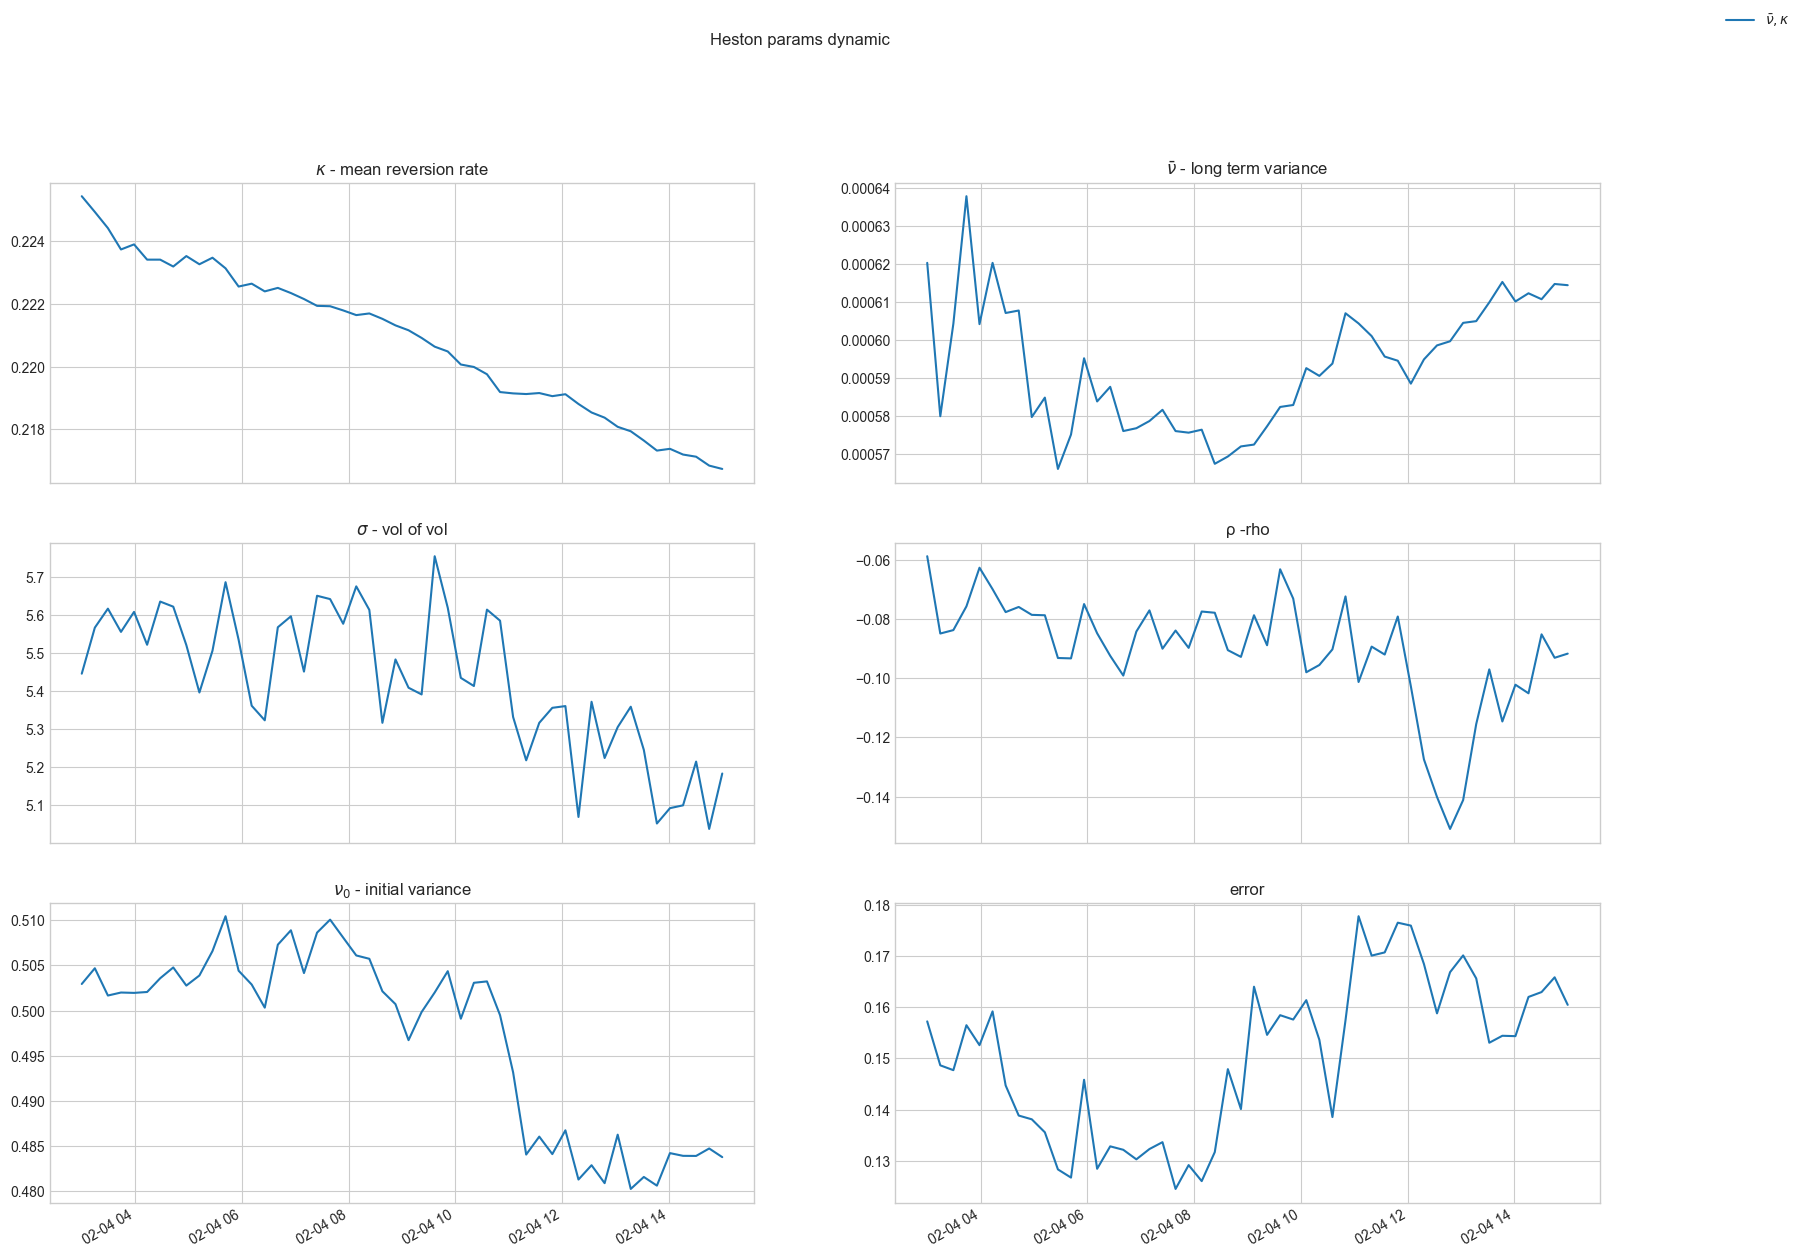

In [37]:
fig, axs =  plt.subplots(nrows=3, ncols=2, figsize=(20, 15))

if to_calibrate["all"]:
    axs[0, 0].plot(timestamps_hm, params_all[0])
    axs[0, 1].plot(timestamps_hm, params_all[1])
    axs[1, 0].plot(timestamps_hm, params_all[2], label = "all params")
    axs[1, 1].plot(timestamps_hm, params_all[3])
    axs[2, 0].plot(timestamps_hm, params_all[4])
    axs[2, 1].plot(timestamps_hm, errors_all)

if to_calibrate["nu0"]:
    axs[0, 0].plot(timestamps_hm, params_nu0[0])
    axs[0, 1].plot(timestamps_hm, params_nu0[1])
    axs[1, 0].plot(timestamps_hm, params_nu0[2], label = r"$\nu_0$")
    axs[1, 1].plot(timestamps_hm, params_nu0[3])
    axs[2, 0].plot(timestamps_hm, params_nu0[4])
    axs[2, 1].plot(timestamps_hm, errors_nu0)

if to_calibrate["nu0_and_nu_bar"]:  
    axs[0, 0].plot(timestamps_hm, params_nu0_and_nu_bar[0])
    axs[0, 1].plot(timestamps_hm, params_nu0_and_nu_bar[1])
    axs[1, 0].plot(timestamps_hm, params_nu0_and_nu_bar[2], label = r"$\nu_0, \bar{\nu}$")
    axs[1, 1].plot(timestamps_hm, params_nu0_and_nu_bar[3])
    axs[2, 0].plot(timestamps_hm, params_nu0_and_nu_bar[4])
    axs[2, 1].plot(timestamps_hm, errors_nu0_and_nu_bar)

if to_calibrate["nu0_and_k"]:
    axs[0, 0].plot(timestamps_hm, params_nu0_and_k[0])
    axs[0, 1].plot(timestamps_hm, params_nu0_and_k[1])
    axs[1, 0].plot(timestamps_hm, params_nu0_and_k[2], label = r"$\nu_0, \kappa$")
    axs[1, 1].plot(timestamps_hm, params_nu0_and_k[3])
    axs[2, 0].plot(timestamps_hm, params_nu0_and_k[4])
    axs[2, 1].plot(timestamps_hm, errors_nu0_and_k)

if to_calibrate["kappa"]:
    axs[0, 0].plot(timestamps_hm, params_kappa[0])
    axs[0, 1].plot(timestamps_hm, params_kappa[1])
    axs[1, 0].plot(timestamps_hm, params_kappa[2], label = r"$\kappa$")
    axs[1, 1].plot(timestamps_hm, params_kappa[3])
    axs[2, 0].plot(timestamps_hm, params_kappa[4])
    axs[2, 1].plot(timestamps_hm, errors_kappa)

if to_calibrate["nu_bar_and_k"]:
    axs[0, 0].plot(timestamps_hm, params_nu_bar_and_k[0])
    axs[0, 1].plot(timestamps_hm, params_nu_bar_and_k[1])
    axs[1, 0].plot(timestamps_hm, params_nu_bar_and_k[2], label = r"$\bar{\nu}, \kappa$")
    axs[1, 1].plot(timestamps_hm, params_nu_bar_and_k[3])
    axs[2, 0].plot(timestamps_hm, params_nu_bar_and_k[4])
    axs[2, 1].plot(timestamps_hm, errors_nu_bar_and_k)


axs[0, 0].set_title(r"$\kappa$ - mean reversion rate")
axs[0, 1].set_title(r"$\bar{\nu}$ - long term variance")
axs[1, 0].set_title(r"$\sigma$ - vol of vol")
axs[1, 1].set_title("ρ -rho")
axs[2, 0].set_title(r"$\nu_0$ - initial variance")
axs[2, 1].set_title("error")


plt.figlegend() 
fig.suptitle("Heston params dynamic")
plt.gcf().autofmt_xdate()
plt.show()

# Vol smile

In [ ]:
stamp = df.sample(1).iloc[0].timestamp
# print(df.timestamp.max() - df.timestamp.min())
print(stamp)

In [20]:
# 1673321843011000
needed_stamp = 1673321843011000
a = np.float64(1.0)  # kappa    a                 |  mean reversion rate | kappa (Article) | kappa (Roland's)
b = np.float64(1.3)  # v_infinity                |  long term variance | nu_bar           | alpha_bar 
c = np.float64(1.0)  # sigma                    |  volatility of volatility | sigma      | mu
rho = np.float64(-0.4)  # rho                    |  correlation between spot and vol |rho | rho
v0 = np.float64(0.65) # init variance            | initial variance | nu_0                | alpha_0
start_params = np.array([a, b, c, rho, v0])

pars_all, err_all, C_all = calibrate_heston(df = df, start_params = start_params, timestamp = needed_stamp,
                                calibration_type= "all")

pars_nu0, err_nu0, C_nu0 = calibrate_heston(df= df, start_params = start_params, timestamp = needed_stamp,
                                calibration_type= "nu0")

pars_and_nu_bar, err_and_nu_bar, C_and_nu_bar = calibrate_heston(df= df, start_params = start_params, 
                                                                 timestamp = needed_stamp,
                                calibration_type= "nu0_and_nu_bar")

pars_nu0_and_k, err_nu0_and_k, C_nu0_and_k = calibrate_heston(df= df, start_params = start_params, 
                                                                 timestamp = needed_stamp,
                                calibration_type= "nu0_and_k")

pars_kappa, err_kappa, C_kappa = calibrate_heston(df= df, start_params = start_params, 
                                                    timestamp = needed_stamp,
                                calibration_type= "kappa")
    

print("All:")
print(round_params(pars_all))
print(err_all)
print("   ")
print(r"$\nu_0$")
print(round_params(pars_nu0))
print(err_nu0)
print("   ")
print(r"$\nu_0, \bar{\nu}$")
print(round_params(pars_and_nu_bar, 7))
print(err_and_nu_bar)
print("   ")
print(r"$\nu_0, \kappa$")
print(round_params(pars_nu0_and_k))
print(err_nu0_and_k)
print("   ")
print(r"$\kappa$")
print(round_params(pars_kappa))
print(err_kappa)
print("   ")

All:
[88.732, 0.3, 18.596, -0.095, 0.47]
0.10336662438207314
   
$\nu_0$
[0.496, 3.711, 8.016, -0.097, 0.339]
0.14459992091863605
   
$\nu_0, \bar{\nu}$
[0.0001, 0.0003807, 6.663357, -0.117194, 0.3385814]
0.15315476617192547
   
$\nu_0, \kappa$
[0.378, 4.736, 8.0, -0.097, 0.339]
0.14465788030683852
   
$\kappa$
[0.378, 0.0, 8.054, -0.092, 0.37]
0.13736845378361187
   


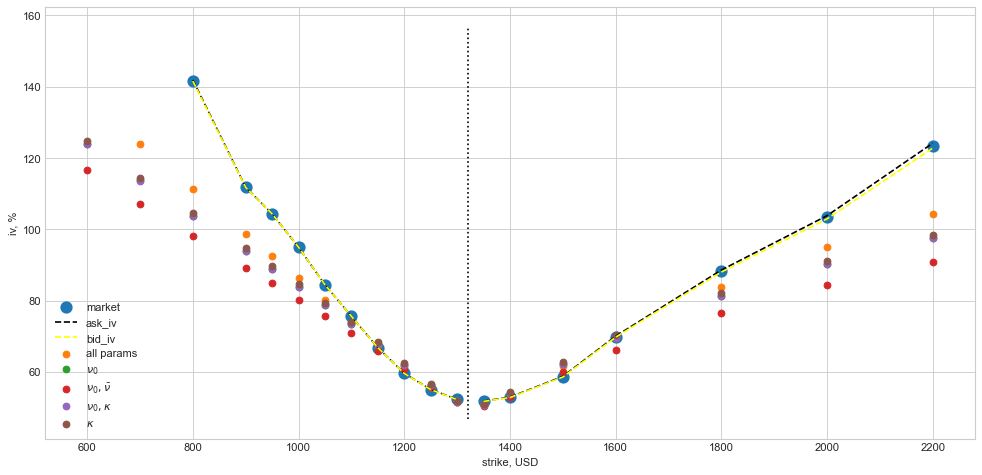

In [26]:
figure(figsize=(15, 7), dpi=80)

exp = C_all.sample(1).expiration.iloc[0]
C_sing_exp_all = C_all[C_all["expiration"] == exp]
C_sing_exp_nu0 = C_nu0[C_nu0["expiration"] == exp]
C_sing_exp_and_nu_bar = C_and_nu_bar[C_and_nu_bar["expiration"] == exp]
C_sing_exp_nu0_and_k = C_nu0_and_k[C_nu0_and_k["expiration"] == exp]
C_sing_exp_kappa = C_kappa[C_kappa["expiration"] == exp]

plt.scatter(C_sing_exp_all["strike_price"], C_sing_exp_all["market_iv"], label = "market", linewidths = 5)

# bid,ask iv
plt.plot(C_sing_exp_all["strike_price"], C_sing_exp_all["ask_iv"], '--', label = "ask_iv", color = "black")
plt.plot(C_sing_exp_all["strike_price"], C_sing_exp_all["bid_iv"], '--', label = "bid_iv", color = "yellow")

plt.scatter(C_sing_exp_all["strike_price"], C_sing_exp_all["calibrated_iv"], label = "all params")
plt.scatter(C_sing_exp_nu0["strike_price"], C_sing_exp_nu0["calibrated_iv"], label = r"$\nu_0$")
plt.scatter(C_sing_exp_and_nu_bar["strike_price"], C_sing_exp_and_nu_bar["calibrated_iv"], label = r"$\nu_0, \bar{\nu}$")
plt.scatter(C_sing_exp_nu0_and_k["strike_price"], C_sing_exp_nu0_and_k["calibrated_iv"], label = r"$\nu_0, \kappa$")
plt.scatter(C_sing_exp_kappa["strike_price"], C_sing_exp_kappa["calibrated_iv"], label = r"$\kappa$")

plt.vlines([C_sing_exp_all.underlying_price.mean()], C_sing_exp_all.market_iv.min()-5, 
           C_sing_exp_all.market_iv.max() + 15, color = "black", linestyles = "dotted")

plt.xlabel("strike, USD")
plt.ylabel("iv, %")
plt.legend()
plt.show()

# References

* [\[Andersen2007\]](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=946405) Andersen, L.B., 2007. Efficient simulation of the Heston stochastic volatility model. Available at SSRN 946405.
* [Grzelak2019] Grzelak, L.A. et al. *Mathematical Modeling and Computation in Finance: With Exercises and Python and MATLAB Computer Codes*, World Scientific Pub. (2019)
* [\[Cui2017\]](https://www.sciencedirect.com/science/article/pii/S0377221717304460) Cui, Y. et al. *Full and fast calibration of the Heston stochastic volatility model.* European Journal of Operational Research 263.2 (2017)